In [1]:
%%capture
# move to src folder so we can import code
%cd ../src

In [5]:
import config
from common.kaggle import download_dataset
# This import * is an extremely bad practice in modern Python programming. This shouldn’t be done in production
from fastai.vision.all import *
from fastcore.xtras import Path

In [3]:
set_seed(config.SEED)

In [4]:
download_dataset("agrigorev", "clothing-dataset-full", input_path=config.INPUTS)

['images_compressed', 'images.csv', 'images_original']


In [18]:
Path.BASE_PATH = config.INPUTS
data_path = Path(config.INPUTS)
data_path.ls()

(#3) [Path('images_compressed'),Path('images.csv'),Path('images_original')]

In [19]:
(data_path/"images_compressed").ls()[:3]

(#3) [Path('images_compressed/16740066-3329-4165-884a-25c42814d590.jpg'),Path('images_compressed/e0b088bd-41de-4b38-b6e8-c2d3b2bbc53c.jpg'),Path('images_compressed/1fae982c-5248-4f9f-8140-841e3110e37c.jpg')]

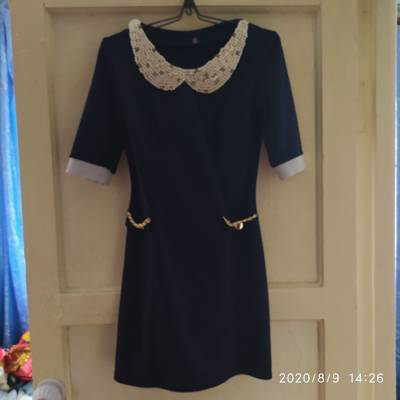

In [11]:
im_path = (data_path/"images_compressed").ls()[0]
im = Image.open(im_path)
im

In [12]:
im.shape

(400, 400)

In [20]:
im_path = (data_path/"images_original").ls()[0]
im = Image.open(im_path)
im.shape

(3000, 3000)

original images are too big, so we are training on compressed dataset

Let's check now if there are any malformed/corrupted images

In [16]:
bad_imgs = []
for im in (data_path/"images_compressed").ls():
    try:
        _ = Image.open(im)
    except:
        bad_imgs.append(im)
        im.unlink()  # remove image

In [17]:
len(bad_imgs)

6

In [21]:
df = pd.read_csv(data_path/'images.csv')
df.head()

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False


"Not sure" labels seems to be unlabeled data, so maybe it is better to delete it. Another way would be to try to label it by using a trained model :)

In [23]:
len(df[df["label"] == "Not sure"])/len(df) * 100

4.21987784564131

Let's clean the data

In [24]:
clean_df = df[~(df["label"] == "Not sure")]
for img in bad_imgs:
    clean_df = clean_df[clean_df["image"] != img.stem]

In [25]:
clean_df["label"].unique(), len(clean_df["label"].unique())

(array(['T-Shirt', 'Shoes', 'Shorts', 'Shirt', 'Pants', 'Skirt', 'Other',
        'Top', 'Outwear', 'Dress', 'Body', 'Longsleeve', 'Undershirt',
        'Hat', 'Polo', 'Blouse', 'Hoodie', 'Skip', 'Blazer'], dtype=object),
 19)

So we are classifying over 19 labels. Let's save the cleaned dataset.

In [26]:
import pandas as pd

In [29]:
Path(config.PREPROCESSED).mkdir(parents=True, exist_ok=True)
clean_df.to_csv(Path(config.PREPROCESSED)/"images_clean.csv", index=False)

In [30]:
from learner import get_learner
learner = get_learner()

/opt/miniconda3/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


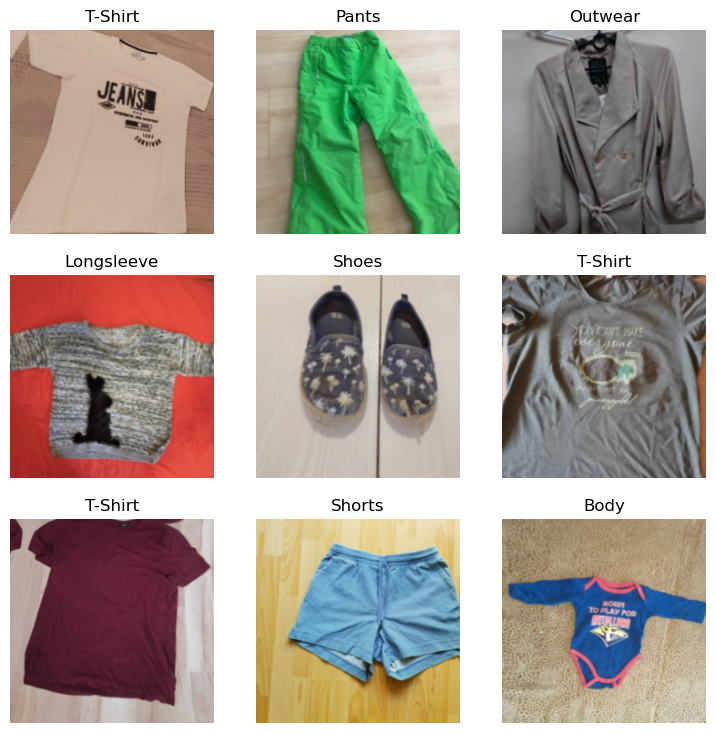

In [31]:
learner.dls.show_batch()